In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors


%matplotlib inline

In [2]:
from copy import deepcopy

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate, find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

# Read processed data

In [3]:
df = pd.read_csv("../Data/NHANES_telomere.csv")

df.head()

,Telomean,HoursWorked,Gender,Age,Race,Education,MaritalStatus,HouseholdIncome
0,0.389337,>=41,Female,<=18,Hispanic,< GED,Single,20k-45k
1,0.389337,21-40,Female,31-50,Other,College,Married,20k-45k
2,0.433244,>=41,Male,>=70,White,GED,Married,<20k
3,0.433244,21-40,Male,31-50,White,College,Married,45k-75k
4,0.443293,>=41,Female,31-50,Other,College,Married,>=75k


In [4]:
hours_worked_map = {
    "<=20": 1,
    "21-40": 2,
    ">=41": 3
}

gender_map = {
    "Female": 1,
    "Male": 2
}

age_map = {
    "<=18": 1,
    "19-30": 2,
    "31-50": 3,
    "51-70": 4,
    ">=70": 5
}

race_map = {
    "White": 1,
    "Black": 2,
    "Hispanic": 3,
    "Other": 4
}

education_map = {
    "< GED": 1,
    "GED": 2,
    "College": 3
}

marital_status_map = {
    "Single": 1,
    "Married": 2,
    "Divorced/Widowed": 3
}

income_map = {
    "<20k": 1,
    "20k-45k": 2,
    "45k-75k": 3,
    ">=75k": 4
}


df["HoursWorked"] = df["HoursWorked"].map(hours_worked_map)
df["Gender"] = df["Gender"].map(gender_map)
df["Age"] = df["Age"].map(age_map)
df["Race"] = df["Race"].map(race_map)
df["Education"] = df["Education"].map(education_map)
df["MaritalStatus"] = df["MaritalStatus"].map(marital_status_map)
df["HouseholdIncome"] = df["HouseholdIncome"].map(income_map)

df.head()

,Telomean,HoursWorked,Gender,Age,Race,Education,MaritalStatus,HouseholdIncome
0,0.389337,3,1,1,3,1,1,2
1,0.389337,2,1,3,4,3,2,2
2,0.433244,3,2,5,1,2,2,1
3,0.433244,2,2,3,1,3,2,3
4,0.443293,3,1,3,4,3,2,4


In [5]:
Z = df.to_numpy()
X = Z[:, [1, 2, 3, 5]]
y = Z[:, 0]
y = y.reshape((-1, 1))

num_data = X.shape[0]
print(f"There are {num_data} data points")

There are 4878 data points


In [6]:
np.unique(X[:, 3])

array([1., 2., 3.])

# Analysis

In [7]:
M = 4
R = np.array([4, 3, 6, 4])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

In [8]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])


# policy_means = loss.compute_policy_means(D, y, num_policies)



# true_best_eff = np.max(mu_policies)
# print(true_best_eff)
# np.where(mu_policies == true_best_eff)

In [9]:
race_profiles = np.unique(Z[:, 4])

all_active_profile = tuple([1] * M)

policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == all_active_profile]
unzipped_temp = list(zip(*policies_temp))
policy_race_idx = list(unzipped_temp[0])
policy_race = list(unzipped_temp[1])


D_race = {}
X_race = {}
y_race = {}
policy_means_race = {}
mu_policies_race = {}
true_best_eff_race = {}
policy_means = np.zeros(shape=(len(policy_race), 2))
for race in race_profiles:
    idx = np.where(Z[:, 4] == race)
    X_race[race] = X[idx, :][0]
    y_race[race] = y[idx, :][0]
    num_data_race = X_race[race].shape[0]
    
    D_race[race] = np.zeros(shape=y_race[race].shape, dtype=np.int64)
    for i in range(num_data_race):
        policy_i = tuple([int(x) for x in X_race[race][i, :]])
        policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
        D_race[race][i, 0] = int(policy_idx[0])


    policy_means_race[race] = loss.compute_policy_means(D_race[race], y_race[race], len(policy_race))
    
    nodata_idx = np.where(policy_means_race[race][:, 1] == 0)[0]
    policy_means_race[race][nodata_idx, 0] = -np.inf
    policy_means_race[race][nodata_idx, 1] = 1
    mu_policies_race[race] = policy_means_race[race][:, 0] / policy_means_race[race][:, 1]
    policy_means_race[race][nodata_idx, 1] = 0

    policy_means_race[race][nodata_idx, 0] = 0
    policy_means += policy_means_race[race]
    policy_means_race[race][nodata_idx, 0] = -np.inf

    true_best_eff_race[race] = np.max(mu_policies_race[race])
    # print(true_best_eff, np.where(mu_policies_race[race] == true_best_eff_race[race]))

nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]
policy_means[nodata_idx, 1] = 0

true_best_eff = np.max(mu_policies)
# print(true_best_eff, np.where(mu_policies == true_best_eff))

In [10]:
D_remapped = D.copy()
range_list = list(np.arange(len(policy_race_idx)))
policy_map = {i: x for i, x in zip(policy_race_idx, range_list)}
D_remapped = np.vectorize(policy_map.get)(D_remapped)

In [32]:
H = 12

# # This is too restrictive
# reg = 1e-2

reg = 2e-3
theta = 1.08

In [33]:
# In the best case, every other profile becomes a single pool
# So max number of pools per profile is adjusted accordingly
# H_profile = H - num_profiles + 1
unordered_factors = race_profiles
num_unordered_factors = len(unordered_factors)
H_profile = H - num_unordered_factors + 1

# Subset data by profiles and find equiv policy lower bound
D_profiles = {}
y_profiles = {}
policies_profiles = {}
policy_means_profiles = {}
eq_lb_profiles = np.zeros(shape=(num_unordered_factors,))
for k, profile in enumerate(unordered_factors):

    policy_profiles_idx_k = policy_race_idx
    policies_profiles[k] = policy_race

    D_k = D_race[profile]
    range_list = list(np.arange(len(policy_profiles_idx_k)))
    policy_map = {i: x for i, x in zip(policy_profiles_idx_k, range_list)}
    D_k = np.vectorize(policy_map.get)(D_k)
    y_k = y_race[profile]
    D_profiles[k] = D_k
    y_profiles[k] = y_k

    if D_k is None:
        policy_means_profiles[k] = None
        eq_lb_profiles[k] = 0
        H_profile += 1
    else:
        policy_means_k = policy_means_race[profile]
        policy_means_profiles[k] = policy_means_k
        eq_lb_profiles[k] = find_profile_lower_bound(D_k, y_k, policy_means_k)

eq_lb_profiles /= num_data
eq_lb_sum = np.sum(eq_lb_profiles)
print(eq_lb_profiles, eq_lb_sum)

# # Now solve each profile independently
# # This step can be parallelized
rashomon_profiles: list[RashomonSet] = [None]*num_unordered_factors
feasible = True
for k, profile in enumerate(unordered_factors):
    theta_k = theta - (eq_lb_sum - eq_lb_profiles[k])
    print(theta_k)
    D_k = D_profiles[k]
    y_k = y_profiles[k]

    policies_k = policies_profiles[k]
    policy_means_k = policy_means_profiles[k]
    profile_mask = list(map(bool, all_active_profile))
    # print(profile_mask)

    # # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    # R_k = R[profile_mask]
    # M_k = np.sum(profile)
    R_k = R
    M_k = M
    # print(len(policies_k), policy_means_k.shape)

    if D_k is None:
        # TODO: Put all possible sigma matrices here and set loss to 0
        rashomon_profiles[k] = RashomonSet(shape=None)
        rashomon_profiles[k].P_qe = [None]
        rashomon_profiles[k].Q = np.array([0])
        continue

    # Control group is just one policy
    if M_k == 0:
        rashomon_k = RashomonSet(shape=None)
        control_loss = eq_lb_profiles[k] + reg
        rashomon_k.P_qe = [None]
        rashomon_k.Q = np.array([control_loss])
    else:
        rashomon_k = RAggregate_profile(M_k, R_k, H_profile, D_k, y_k, theta_k, all_active_profile, reg,
                                        policies_k, policy_means_k, normalize=num_data)
        rashomon_k.calculate_loss(D_k, y_k, policies_k, policy_means_k, reg, normalize=num_data)

    rashomon_k.sort()
    rashomon_profiles[k] = rashomon_k
    if len(rashomon_k) == 0:
        feasible = False

# Combine solutions in a feasible way
if feasible:
    R_set = find_feasible_combinations(rashomon_profiles, theta, H, sorted=True)
else:
    R_set = []
if len(R_set) > 0:
    rashomon_profiles = remove_unused_poolings(R_set, rashomon_profiles)

print(len(R_set))

[0.44485554 0.21814427 0.37217937 0.03920771] 1.0743868880613001
0.45046865448351503
0.22375737882460955
0.37779247979863717
0.04482082270933807
0


In [22]:
rashomon_homogeneous = RAggregate_profile(M, R, H, D_remapped, y, theta, all_active_profile, reg,
                                          policy_race, policy_means, normalize=num_data)
rashomon_homogeneous.calculate_loss(D_remapped, y, policy_race, policy_means, reg, normalize=num_data)

print(len(rashomon_homogeneous))

KeyboardInterrupt: 

In [23]:
R_set_pruned = []

for r in R_set:
    current_sigma = None
    homoegeneous = False
    # homogeneous = True
    # for race in race_profiles:
    #     race = int(race) - 1
    #     sigma_id = r[race]
    #     sigma_race = rashomon_profiles[race].sigma[sigma_id]
    #     if current_sigma is None:
    #         current_sigma = sigma_race
    #     elif not np.array_equal(current_sigma, sigma_race):
    #         homogeneous = False
    #         break
    
    if homogeneous:
        found_in_homogeneous = False
        for idx, r_sigma in enumerate(rashomon_homogeneous.sigma):
            if np.array_equal(r_sigma, current_sigma):
                found_in_homogeneous = True
                R_set_pruned.append([-1, idx])
                break
        if not found_in_homogeneous:
            print("Not found :(")
    else:
        R_set_pruned.append(r)

print(len(R_set_pruned))

1799786


In [24]:
model_losses = []
model_sizes = []

for i, r in enumerate(R_set_pruned):
    if r[0] == -1:
        model_i = r[1]
        loss_i = rashomon_homogeneous.loss[model_i]
        size_i = rashomon_homogeneous.pools[model_i]
    else:
        model_i = r
        loss_i = 0
        size_i = 0
        for race, race_model in enumerate(model_i):
            loss_i += rashomon_profiles[race].loss[race_model]
            size_i += rashomon_profiles[race].pools[race_model]
    model_losses.append(loss_i)
    model_sizes.append(size_i)

model_losses = np.array(model_losses)
model_sizes = np.array(model_sizes)

best_loss = np.min(model_losses)
worst_loss = np.max(model_losses)

eps = (worst_loss - best_loss) / best_loss
print(f"Best loss = {best_loss}, Worst loss = {worst_loss}, epsilon = {eps}")

Best loss = 1.0943868880613, Worst loss = 1.1343868880613002, epsilon = 0.036550145507371734


In [25]:
model_post_prob = np.exp(-model_losses)
model_post_prob = model_post_prob - np.min(model_post_prob)
model_post_prob = model_post_prob / np.max(model_post_prob)

# Plots

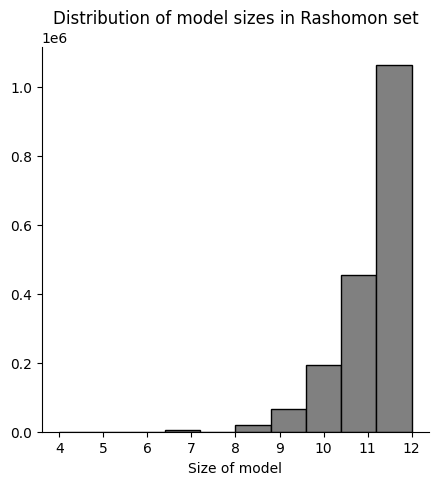

In [26]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes,
        color="grey", edgecolor="black")

# ax.set_xlim(1, H)
ax.set_xlabel("Size of model")
ax.set_ylabel("")
ax.set_title("Distribution of model sizes in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/price_charity/rset_size_dist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_size_dist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()

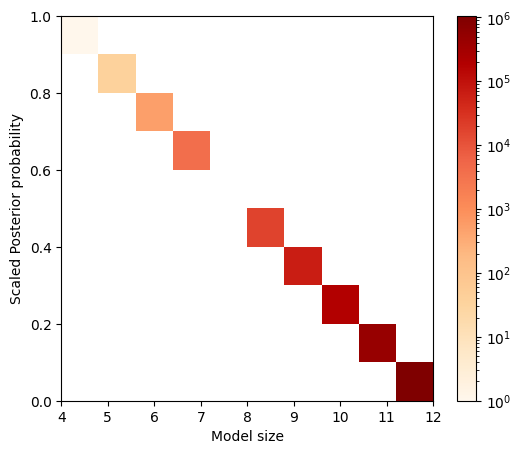

In [27]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes, model_post_prob, norm=colors.LogNorm(),
             cmap="OrRd")
fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)

ax.set_xlabel("Model size")
ax.set_ylabel("Scaled Posterior probability")


# plt.savefig("../Figures/price_charity/rset_2d_hist.png", dpi=300, bbox_inches="tight")
# plt.savefig("../Figures/price_charity/rset_2d_hist_poster.pdf", dpi=600, bbox_inches="tight")
plt.show()